## HW4-Transfer Learning

With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a new related problem. So we reuse initial and middle layers of our pre-trained model to re-train only final layers for our new task. A pre-trained model denotes a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve.

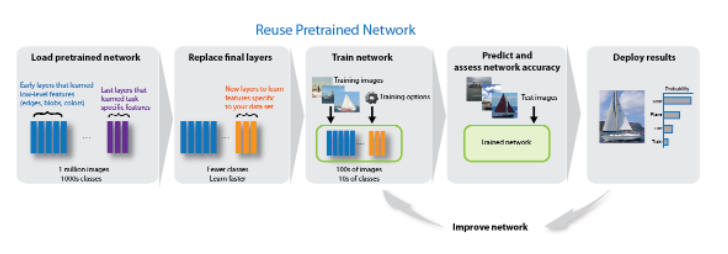

Fine tuning is a way of appliying or utilizing transfer learning. Specifically fine tuning is a process that takes a model that's already been trained for a given task and then tuning or tweaking that model to make it perform a second similiar task. If the two tasks are different and there will be some information that the model has learned that may not apply to our new task or there may be new information that the model needs to learn from the data regarding the new task that wasn't learned from the previous task. 



In this assignment you will implement a transfer learning approach by using weather dataset [1] for image classifitaion task. The dataset consists of a total of 1125 images which are maually labeled as cloudy, sunrise, rainy and sun shine. You will use pre-trained models which are ResNet and InceptionV3 available from Keras [2]. Follow the steps below  to complete the assignment.

[1]: https://data.mendeley.com/datasets/4drtyfjtfy/1

[2]: https://keras.io/api/applications/

**Steps**:

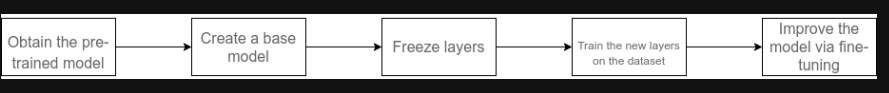


- Obtain the pre-trained model

The first step is to get the pre-trained model that is already given to you. You get pre-trained weights alongside each model. When you download a model, the weights are downloaded automatically. They will be stored in `~/.keras/models/.`

- Create a base model

The first step is to instantiate the base model using the architectures as ResNet and InceptionV3 separately on ImageNet [3]. Download the pre-trained weights. If you don’t download the weights, you will have to use the architecture to train your model from scratch. Recall that the base model will usually have more units in the final output layer than you require. When creating the base model, you, therefore, have to remove the final output layer. Later on, you will add a final output layer that is compatible with your problem. 

- Freeze layers so they don’t change during training

Freezing the layers from the pre-trained model that you do not wish to change is vital. This is because you don’t want the weights in those layers to be changed. If they are, then you may lose all the learning fast. This will be no different from training the model from scratch. Of course, there is an option for slowly changing the weights to tune to the new dataset by specificly providing smaller learning rates for some of the layers to tune to the new dataset slowly. In this case, you do not need to freeze such layers but provide suitable learning rates instead. These selections depend on the problem and the architecture you work with, and should be decided according to some empirical observations.

- Add new trainable layers

The next step is to add new trainable layers that will turn old features into predictions on the new dataset. This is important because the pre-trained model is loaded without the final output layer. 

- Train the new layers on the dataset

Remember that the pre-trained model’s final output will most likely be different from the output that you want for your model.  You will add some new dense layers as you please, but most importantly, a final dense layer with units corresponding to the number of outputs expected by your model. 

- Improve the model via fine-tuning

Once you have done the previous step, you will have a model that can make predictions on your dataset. Now improve its performance through fine-tuning.

- Summarize history for accuracy

Plot a graph to demonstrate accuracy scores in train versus test sets. In your plot use x-axes for epoch and y a-axes for accuracy scores. Don't forget to add your comments for your graph.

**Notes:** 

- You will earn 50 points for each model if you complete all required steps defined above. 

- Don't forget to explain your codes in each step.

- Use separate code cells for each step.

- You can use deep learning frameworks such as Keras, Pytorch etc.

- Due date: 10.05.2022


[3]: https://keras.io/api/applications/#classify-imagenet-classes-with-resnet50








In [1]:
'''Kayla Akyüz 21726914'''

# Checking if packages are installed

'''
%pip install numpy > null 
%pip install pandas > null
%pip install matplotlib > null
%pip install tensorflow > null
%pip install np_utils > null  # np_utils is not a default package you need to install it if you don't have, it is used for one hot encoding
%pip install sklearn > null
'''

# Part 1
# Importing necessary packages for Part 1
import os # Used to read paths from OS
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50 Model for Part 1
from tensorflow.keras.preprocessing import image # Used to proccess image data to trainable data
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions # Processing input and predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, Input # Layer management of keras
from tensorflow.keras.models import Model # For creating the custom models
from tensorflow.keras.optimizers import Adam # Adam optimizer
# np_utils is not a default package you need to install it with %pip install np_utils!
from keras.utils import np_utils # Used for one hot encoding
from sklearn.utils import shuffle # Used to shuffle data
from sklearn.model_selection import train_test_split # Used to split data
import numpy as np # Numpy for array operations
import matplotlib.pyplot as plt # Used to plot the results
import tensorflow as tf # Importing tensorflow as tf so we can switch device

Above libraries need to be imported, make sure to install np_utils and tensorflow and other libraries. I am using GPU envoriment but it has chance of throwing OOM so I set below to use cpu:0. You can change that or remove if you have not set CUDA or you won't get OOM. It gives OOM cuz GPU memory freeing does not occur.

In [2]:
# Part 1
# First loading training data
_path_ = os.getcwd() # Getting current directory
database = _path_ + "/dataset" # Adding dataset folder to path
database_list = os.listdir(database) # Getting all sub folders of path
class_num = len(database_list) # Class num is obtained as number of folders in database
img_data_list = [] # Empty array for image data

# Obtaining pre trained model
for dataset in database_list: # Iterating for all folders
    img_list = os.listdir(database+'/'+ dataset) # Getting paths of all images in that folder
    for img in img_list: # Iterating for all image paths
        img_file = image.load_img(database + '/'+ dataset + '/'+ img , target_size=(224, 224)) # Loading image file at the directory and resizing it to 224, 224
        img_data_list.append(preprocess_input(np.expand_dims(image.img_to_array(img_file), axis=0))) # Converting image to array data of 224, 224, 3 dimensions and storing

img_data = np.rollaxis(np.array(img_data_list),1,0) # Converting the database to np array and getting the extra dimension to first
img_data = img_data[0] # Getting rid of the extra dimension at the end we have database of shape (1125, 224, 224, 3)
num_of_samples = img_data.shape[0]
print(img_data.shape) # Printing shape for checking


(1125, 224, 224, 3)


We initialize data using preprocess_input of ResNet50 by iterating the folders and getting all images.

In [3]:
# Initalizing the training sets
labels = np.ones((num_of_samples,),dtype='int64') # Creating Y data of training

labels[0:300]=0 # 300 Cloudy class 0
labels[300:515]=1 # 215 Rainy class 1
labels[515:768]=2 # 253 Shiny class 2
labels[768:]=3 # 357 Sunrise class 3 Total 1125 

Y = np_utils.to_categorical(labels, class_num) # One hot encoding the labels

x,y = shuffle(img_data,Y, random_state=42) # Shuffling the train data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # Splitting the train data in to sets

Splitting Test, Train sets.

In [4]:
# Obtain the pre-trained model
model_resnet_raw = ResNet50(input_tensor=Input(shape=(224, 224, 3)), include_top=False, weights='imagenet') # Creating ResNet50 model with ImageNet weights

Getting pre trained model, setting include top to false, getting imagenet weights for the model.

In [5]:
# Create a base model
resnet_layers = model_resnet_raw.output # Getting current model

layers = GlobalAveragePooling2D()(resnet_layers) # Adding a global average pooling layer
layers = Dense(512, activation='relu',name='fc-1')(layers) # Adding fully-connected NN layer
layers = Dropout(0.5)(layers) # Adding dropout layer
layers = Dense(256, activation='relu',name='fc-2')(layers)
layers = Dropout(0.5)(layers)

resnet_out = Dense(class_num, activation='softmax', name='output_layer')(layers) # Adding a softmax layer
model_resnet = Model(inputs=model_resnet_raw.input, outputs=resnet_out) # Creating new model with the extra layers

Creating a model for training, getting the output layers of ResNet and adding 6 layers on top of it, Average pooling layer, full-connected&drop out layers and softmax layer.

In [6]:
# Freezing layers so they don’t change during training
for layer in model_resnet.layers[:-6]: # Iterating except last 6 layers which we will train
    layer.trainable = False # Freezing them by setting trainable False

Freezing layers we won't train.

Add new trainable layers
No need to add new trainable layers since we already drop the layer and add new layers while creating new base model

In [7]:
# Setting model for training
model_resnet.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Configuring the model for training

Compiling the model, configuring it for training. Using categorical_crossentropy as it is used for one hot encoding.

In [8]:
# Train the new layers on the dataset

with tf.device('/cpu:0'): # Using CPU it is slower but GPU might give OOM error, chose this as you wish or remove.
    resnet_train_history = model_resnet.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test)) # Training the model with epoch 8
    (resnet_loss, resnet_accuracy) = model_resnet.evaluate(X_test, y_test, batch_size=10, verbose=1) # Getting loss and accuracy values of the trained model

Epoch 1/10
29/29 [==============================] - 56s 2s/step - loss: 0.6311 - accuracy: 0.7811 - val_loss: 0.2120 - val_accuracy: 0.9156
Epoch 2/10
29/29 [==============================] - 52s 2s/step - loss: 0.1998 - accuracy: 0.9367 - val_loss: 0.1893 - val_accuracy: 0.9333
Epoch 3/10
29/29 [==============================] - 51s 2s/step - loss: 0.1000 - accuracy: 0.9589 - val_loss: 0.1557 - val_accuracy: 0.9467
Epoch 4/10
29/29 [==============================] - 54s 2s/step - loss: 0.0745 - accuracy: 0.9767 - val_loss: 0.1340 - val_accuracy: 0.9556
Epoch 5/10
29/29 [==============================] - 52s 2s/step - loss: 0.0689 - accuracy: 0.9800 - val_loss: 0.1446 - val_accuracy: 0.9556
Epoch 6/10
29/29 [==============================] - 52s 2s/step - loss: 0.0777 - accuracy: 0.9767 - val_loss: 0.1545 - val_accuracy: 0.9511
Epoch 7/10
29/29 [==============================] - 52s 2s/step - loss: 0.0606 - accuracy: 0.9822 - val_loss: 0.1234 - val_accuracy: 0.9600
Epoch 8/10
29/29 [==

Using CPU makes it slow but avoids OOM errors. Getting around 96% accuracy. Using verbose = 1 so we got print result. With my tests 10 epoch seemed enough, not overfitting and producing good models.

In [9]:
print("Resnet Model Without Fine Tuning: loss = {:.4f}, accuracy = {:.4f}%".format(resnet_loss, resnet_accuracy * 100))

Resnet Model Without Fine Tuning: loss = 0.1176, accuracy = 96.0000%


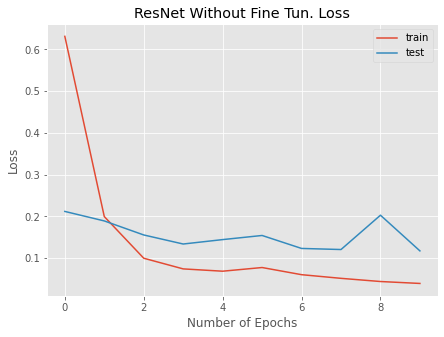

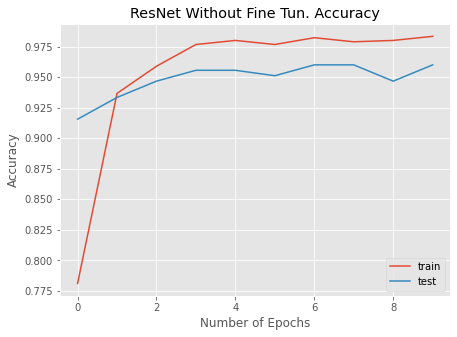

In [10]:
# Summarize history for accuracy
# Plotting result without fine tuning

train_loss=resnet_train_history.history['loss'] # Getting loss datas from train history
val_loss=resnet_train_history.history['val_loss'] # Getting val_loss datas from train history
train_acc=resnet_train_history.history['accuracy'] # Getting accuracy datas from train history
val_acc=resnet_train_history.history['val_accuracy'] # Getting val_accuracy datas from train history
xc=range(10) # Setting x range to 10 as we used 10 epoch

# Plotting loss vs val_loss plot
plt.style.use(['ggplot']) # Setting style
plt.figure(1,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_loss) # Setting first bar for train loss
plt.plot(xc,val_loss) # Setting second bar for test loss
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Loss') # Setting ylabel
plt.title('ResNet Without Fine Tun. Loss') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test']) # Adding legend to plot

# Plotting accuracy vs val_accuracy plot
plt.figure(2,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_acc) # Setting first bar for train accuracy
plt.plot(xc,val_acc) # Setting first bar for test accuracy
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Accuracy') # Setting ylabel
plt.title('ResNet Without Fine Tun. Accuracy') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test'], loc=4) # Adding legend to plot

We can see with the data here, after 2 epochs we can easily get ãround 95% accuracy due to already trained model beeing good. At epoch 4 the model seems to be reaching it's max effiency and at epoch 5 it signals that it might get overfitted if we keep going on. Regardless at the end of 10 epochs the model performs  with great accuracy without overfitting. even it signaled like such model recovers. We can also see similar result with loss when at epoch 8 it is signalling but at the end result is satisfying. Ofcourse comparing orange with blue we can see it gets better results for train set, even tho initially test set gives better result probably due being small and randomly accurate.

In [11]:
# Improve the model via fine-tuning

with tf.device('/cpu:0'): # Using CPU it is slower but GPU might give OOM error, chose this as you wish or remove.
    model_resnet.trainable = True # Unfreezing all layers so we can fine tune
    model_resnet.compile(optimizer=Adam(1e-5),  # Configuring the model train with very low learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    resnet_ft_train_history = model_resnet.fit(X_train, y_train, epochs=4, verbose=1, validation_data=(X_test, y_test)) # Fitting the model with epoch 4 anything above 4 will cause overfitting
    (resnet_ft_loss, resnet_ft_accuracy) = model_resnet.evaluate(X_test, y_test, batch_size=10, verbose=1) # Getting loss and accuracy values of the trained model

Epoch 1/4
29/29 [==============================] - 207s 7s/step - loss: 0.7391 - accuracy: 0.8033 - val_loss: 0.1177 - val_accuracy: 0.9644
Epoch 2/4
29/29 [==============================] - 203s 7s/step - loss: 0.2416 - accuracy: 0.9289 - val_loss: 0.1319 - val_accuracy: 0.9644
Epoch 3/4
29/29 [==============================] - 204s 7s/step - loss: 0.1307 - accuracy: 0.9611 - val_loss: 0.1364 - val_accuracy: 0.9600
Epoch 4/4
23/23 [==============================] - 11s 495ms/step - loss: 0.1385 - accuracy: 0.9556


Fine Tuning means we first unfreeze all model and train it with very small learning rate. Since our model is already getting 96% accuracy fine tuning it could result in overfitting. I chose epoch 4 since anything bigger was messing model too much. With epoch 4 it overfits sometimes as well. May be even smaller epoch or could use no fine tuning for the model.

In [12]:
print("Resnet Model With Fine Tuning: loss = {:.4f}, accuracy = {:.4f}%".format(resnet_ft_loss,resnet_ft_accuracy * 100))

Resnet Model With Fine Tuning: loss = 0.1385, accuracy = 95.5556%


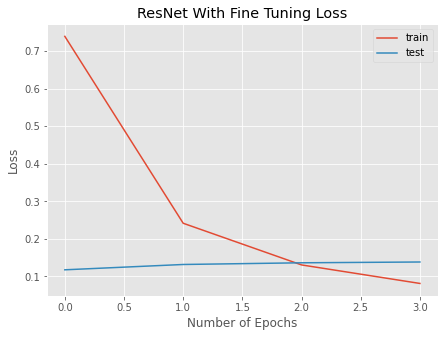

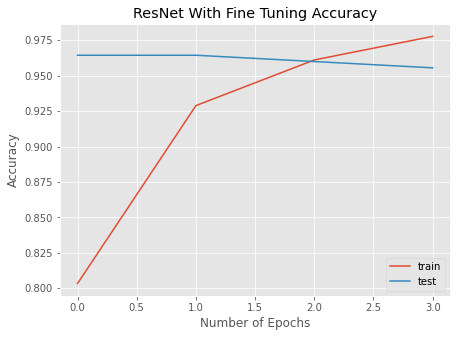

In [13]:
# Summarize history for accuracy
# Plotting result with fine tuning

train_loss=resnet_ft_train_history.history['loss'] # Getting loss datas from train history
val_loss=resnet_ft_train_history.history['val_loss'] # Getting val_loss datas from train history
train_acc=resnet_ft_train_history.history['accuracy'] # Getting accuracy datas from train history
val_acc=resnet_ft_train_history.history['val_accuracy'] # Getting val_accuracy datas from train history
xc=range(4) # Setting x range to 4 as we used 4 epoch for fine tuning

# Plotting loss vs val_loss plot
plt.style.use(['ggplot']) # Setting style
plt.figure(1,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_loss) # Setting first bar for train loss
plt.plot(xc,val_loss) # Setting second bar for test loss
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Loss') # Setting ylabel
plt.title('ResNet With Fine Tuning Loss') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test']) # Adding legend to plot

# Plotting accuracy vs val_accuracy plot
plt.figure(2,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_acc) # Setting first bar for train accuracy
plt.plot(xc,val_acc) # Setting first bar for test accuracy
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Accuracy') # Setting ylabel
plt.title('ResNet With Fine Tuning Accuracy') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test'], loc=4) # Adding legend to plot

Here we can see fine tuning reduced the accuracy from 96% to 95% and increased loss. Even tho epoch was small it overfitted. We can also realize it is overfitting by +97% accuracy for train set, it is getting really high for a model. With my tests after 5 epoch towards 10th it reached 99% for train data and went down to 93% for test data so increasing the epoch beyond 5 messes up model badly. We can see similar result with the loss.

-----------END OF PART 1-----------

In [14]:
# Part 2
# Importing necessary packages for Part 2
import os # Used to read paths from OS
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3 Model for Part 2
from tensorflow.keras.preprocessing import image # Used to proccess image data to trainable data
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions # Processing input and predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, Input # Layer management of keras
from tensorflow.keras.models import Model # For creating the custom models
from tensorflow.keras.optimizers import Adam # Adam optimizer
# np_utils is not a default package you need to install it with %pip install np_utils!
from keras.utils import np_utils # Used for one hot encoding
from sklearn.utils import shuffle # Used to shuffle data
from sklearn.model_selection import train_test_split # Used to split data
import numpy as np # Numpy for array operations
import matplotlib.pyplot as plt # Used to plot the results
import tensorflow as tf # Importing tensorflow as tf so we can switch device

Importing libraries for part 2. Make sure you have installed libraries and importing again. Some libraries and methods are different. For example here we are going to use preprocess_input from inception_v3.

In [15]:
# Loading training data, these parts are the same as part 1 but produce different result due different preprocess input, must use/run for meaningfull result
_path_ = os.getcwd() # Getting current directory
database = _path_ + "/dataset" # Adding dataset folder to path
database_list = os.listdir(database) # Getting all sub folders of path
class_num = len(database_list) # Class num is obtained as number of folders in database
img_data_list = [] # Empty array for image data

# Obtaining pre trained model
for dataset in database_list: # Iterating for all folders
    img_list = os.listdir(database+'/'+ dataset) # Getting paths of all images in that folder
    for img in img_list: # Iterating for all image paths
        img_file = image.load_img(database + '/'+ dataset + '/'+ img , target_size=(224, 224)) # Loading image file at the directory and resizing it to 224, 224
        img_data_list.append(preprocess_input(np.expand_dims(image.img_to_array(img_file), axis=0))) # Converting image to array data of 224, 224, 3 dimensions and storing

img_data = np.rollaxis(np.array(img_data_list),1,0) # Converting the database to np array and getting the extra dimension to first
img_data = img_data[0] # Getting rid of the extra dimension at the end we have database of shape (1125, 224, 224, 3)
num_of_samples = img_data.shape[0]
print(img_data.shape) # Printing shape for checking

(1125, 224, 224, 3)


Initializing the image datas with inception_v3's preprocess_input.

In [16]:
# Initalizing the training sets
labels = np.ones((num_of_samples,),dtype='int64') # Creating Y data of training

labels[0:300]=0 # 300 Cloudy class 0
labels[300:515]=1 # 215 Rainy class 1
labels[515:768]=2 # 253 Shiny class 2
labels[768:]=3 # 357 Sunrise class 3 Total 1125 

Y = np_utils.to_categorical(labels, class_num) # One hot encoding the labels

x,y = shuffle(img_data,Y, random_state=42) # Shuffling the train data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # Splitting the train data in to sets

Creating Train and Test splits for the data

In [17]:
# Obtain the pre-trained model
model_inception_raw = InceptionV3(input_tensor=Input(shape=(224, 224, 3)), include_top=False, weights='imagenet') # Creating InceptionV3 model with ImageNet weights

Obtaining a pretrained InceptionV3 model with include top False and imagenet weights

In [18]:
# Create a base model
inception_layers = model_inception_raw.output # Getting current model

layers_i = GlobalAveragePooling2D()(inception_layers) # Adding a global average pooling layer
layers_i = Dense(512, activation='relu',name='fc-1')(layers_i) # Adding fully-connected NN layer
layers_i = Dropout(0.5)(layers_i) # Adding dropout layer
layers_i = Dense(256, activation='relu',name='fc-2')(layers_i)
layers_i = Dropout(0.5)(layers_i)

inception_out = Dense(class_num, activation='softmax', name='output_layer')(layers_i) # Adding a softmax layer
model_inception= Model(inputs=model_inception_raw.input, outputs=inception_out) # Creating new model with the extra layers

Creating a new model from the output of InceptionV3, adding 6 layers, global average pooling layer, fully-connected&drop out layers and softmax layer.

In [19]:
# Freezing layers so they don’t change during training
for layer in model_inception.layers[:-6]: # Iterating except last 6 layers which we will train
    layer.trainable = False # Freezing them by setting trainable to False

Freezing the layers we won't train to preserve them.

In [20]:
# Setting model for training
model_inception.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Configuring the model for training

Compling model for train configuration. Using categorical_crossentropy as it is used for one hot encoding.

In [21]:
# Train the new layers on the dataset

with tf.device('/cpu:0'): # Using CPU it is slower but GPU might give OOM error, chose this as you wish or remove.
    inception_train_history = model_inception.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test)) # Training the model with epoch 12 
    (inception_loss, inception_accuracy) = model_inception.evaluate(X_test, y_test, batch_size=10, verbose=1) # Getting loss and accuracy data

Epoch 1/10
29/29 [==============================] - 34s 1s/step - loss: 1.0668 - accuracy: 0.6089 - val_loss: 0.3418 - val_accuracy: 0.8800
Epoch 2/10
29/29 [==============================] - 30s 1s/step - loss: 0.4728 - accuracy: 0.8367 - val_loss: 0.2863 - val_accuracy: 0.9022
Epoch 3/10
29/29 [==============================] - 30s 1s/step - loss: 0.3179 - accuracy: 0.8967 - val_loss: 0.2452 - val_accuracy: 0.9022
Epoch 4/10
29/29 [==============================] - 30s 1s/step - loss: 0.2552 - accuracy: 0.9256 - val_loss: 0.3050 - val_accuracy: 0.9022
Epoch 5/10
29/29 [==============================] - 30s 1s/step - loss: 0.2572 - accuracy: 0.9200 - val_loss: 0.2167 - val_accuracy: 0.9111
Epoch 6/10
29/29 [==============================] - 30s 1s/step - loss: 0.1733 - accuracy: 0.9489 - val_loss: 0.2345 - val_accuracy: 0.9200
Epoch 7/10
29/29 [==============================] - 30s 1s/step - loss: 0.1629 - accuracy: 0.9422 - val_loss: 0.1979 - val_accuracy: 0.9422
Epoch 8/10
29/29 [==

Training model with epoch 10. We can see at epoch 6-10 the result stars being average. Later on we can further improve with fine tuning.

In [22]:
print("InceptionV3 Model Without Fine Tuning: loss = {:.4f}, accuracy = {:.4f}%".format(inception_loss, inception_accuracy * 100))

InceptionV3 Model Without Fine Tuning: loss = 0.2369, accuracy = 92.4444%


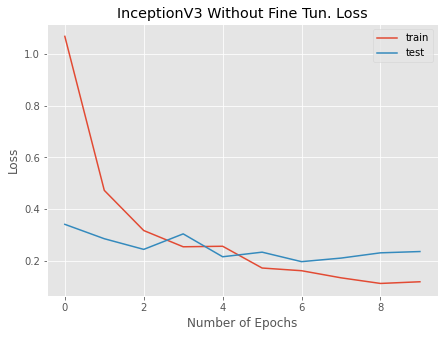

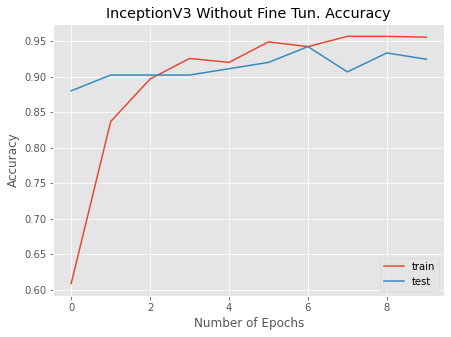

In [23]:
# Summarize history for accuracy
# Plotting result without fine tuning

train_loss=inception_train_history.history['loss'] # Getting loss datas from train history
val_loss=inception_train_history.history['val_loss'] # Getting val_loss datas from train history
train_acc=inception_train_history.history['accuracy'] # Getting accuracy datas from train history
val_acc=inception_train_history.history['val_accuracy'] # Getting val_accuracy datas from train history
xc=range(10) # Setting x range to 10 as we used 10 epoch

# Plotting loss vs val_loss plot
plt.style.use(['ggplot']) # Setting style
plt.figure(1,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_loss) # Setting first bar for train loss
plt.plot(xc,val_loss) # Setting second bar for test loss
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Loss') # Setting ylabel
plt.title('InceptionV3 Without Fine Tun. Loss') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test']) # Adding legends to plot

# Plotting accuracy vs val_accuracy plot
plt.figure(2,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_acc) # Setting first bar for train accuracy
plt.plot(xc,val_acc) # Setting first bar for test accuracy
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Accuracy') # Setting ylabel
plt.title('InceptionV3 Without Fine Tun. Accuracy') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test'], loc=4) # Adding legends to plot

Here in these graphs we can see the accuracy has a deep value at epoch 7, this might be signalling overfitting. With my tests after epoch 15 the model was definetly overfitting. With the result of 93% we can improve it further by fine tuning. ResNet model was 96% and it only got overfitted with finetuning so keeping room for improvement is good here. We can see comparing test and train data since train data has small amount and it seems to be gotten initially more predictible images. Loss has similar results with room to improvement.

In [24]:
# Improve the model via fine-tuning

with tf.device('/cpu:0'): # Using CPU for this part, it needs around 5.4gb my GPU did not have, you can remove this if you got enough memory or you are not using GPU at all
    model_inception.trainable = True # Unfreezing all layers so we can fine tune
    model_inception.compile(optimizer=Adam(1e-5),  # Configuring the model train with very low learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    inception_ft_train_history = model_inception.fit(X_train, y_train, epochs=5, verbose=1, validation_data=(X_test, y_test)) # Fitting the model setting epoch 5 as anything above will cause overfitting
    (inception_ft_loss, inception_ft_accuracy) = model_inception.evaluate(X_test, y_test, batch_size=10, verbose=1) # Getting loss and accuracy values of the trained model

Epoch 1/5
29/29 [==============================] - 135s 4s/step - loss: 1.7488 - accuracy: 0.5100 - val_loss: 0.1942 - val_accuracy: 0.9378
Epoch 2/5
29/29 [==============================] - 128s 4s/step - loss: 0.6867 - accuracy: 0.7489 - val_loss: 0.1668 - val_accuracy: 0.9422
Epoch 3/5
29/29 [==============================] - 128s 4s/step - loss: 0.3875 - accuracy: 0.8522 - val_loss: 0.1654 - val_accuracy: 0.9467
Epoch 4/5
29/29 [==============================] - 129s 4s/step - loss: 0.2285 - accuracy: 0.9244 - val_loss: 0.1619 - val_accuracy: 0.9422
Epoch 5/5
23/23 [==============================] - 8s 334ms/step - loss: 0.1659 - accuracy: 0.9511


Fine tuning is basically unfreezing the whole model and training it with low learning rate. We can see after fine tuning we are able to achieve better model gradualy. With this model since there is room for improvement I set epoch as 5. Could be 6-7 but at 10 it was starting to get overfitting definetly. Since 95% is not that bad I kept it at epoch 5. Keep in mind doing this on CPU might be very slow.

In [25]:
print("InceptionV3 Model With Fine Tuning: loss = {:.4f}, accuracy = {:.4f}%".format(inception_ft_loss,inception_ft_accuracy * 100))

InceptionV3 Model With Fine Tuning: loss = 0.1659, accuracy = 95.1111%


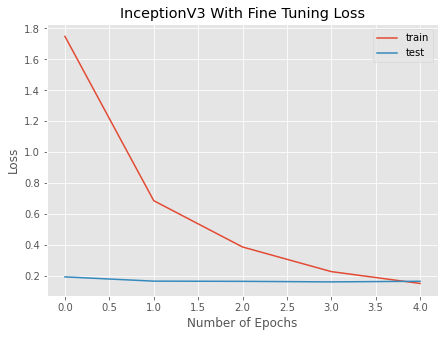

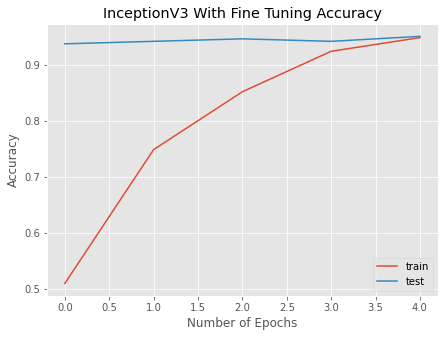

In [26]:
# Summarize history for accuracy
# Plotting result with fine tuning

train_loss=inception_ft_train_history.history['loss'] # Getting loss datas from train history
val_loss=inception_ft_train_history.history['val_loss'] # Getting val_loss datas from train history
train_acc=inception_ft_train_history.history['accuracy'] # Getting accuracy datas from train history
val_acc=inception_ft_train_history.history['val_accuracy'] # Getting val_accuracy datas from train history
xc=range(5) # Setting x range to 5 as we used 5 epoch for fine tuning

# Plotting loss vs val_loss plot
plt.style.use(['ggplot']) # Setting style
plt.figure(1,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_loss) # Setting first bar for train loss
plt.plot(xc,val_loss) # Setting second bar for test loss
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Loss') # Setting ylabel
plt.title('InceptionV3 With Fine Tuning Loss') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test']) # Adding legend for plot

# Plotting accuracy vs val_accuracy plot
plt.figure(2,figsize=(7,5)) # Setting figure size
plt.plot(xc,train_acc) # Setting first bar for train accuracy
plt.plot(xc,val_acc) # Setting first bar for test accuracy
plt.xlabel('Number of Epochs') # Setting xlabel
plt.ylabel('Accuracy') # Setting ylabel
plt.title('InceptionV3 With Fine Tuning Accuracy') # Setting title
plt.grid(True) # Adding grid to plot
plt.legend(['train','test'], loc=4) # Adding legend for plot

Looking at the plot we can see fine tuning did improve our results from 93% to 95%, it did not cause overfitting like the ResNet model even tho we use one more epoch here. I tested up to 10 epochs and it was only then getting overfitted. It seems 95-96% is good accuracy. Similarly the loss value only got better with the fine tuning here. May be epoch could go up to 6-7 however it did not seems to increase beyond 96% on my tests anyway.

-----------END OF PART 2-----------

------------ RESOURCES ------------

keras.io/guides/transfer_learning/

keras.io/api/applications/#classify-imagenet-classes-with-resnet50

-----------------------------------

-Kayla Akyüz- -21726914- -BBM409 Assignment 4-